Produce training set for speculator

In [1]:
import os
import numpy as np 
import astropy.units as u
from astropy.cosmology import Planck13 as cosmo
# -- gqp_mc --
from gqp_mc import util as UT
from gqp_mc import fitters as Fitters
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
speculate = Fitters.iSpeculator(model_name='fsps')

First we need to sample the prior space of our paremeters: 

$$\beta_1, \beta_2, \beta_3, \beta_4, \gamma_1, \gamma_2, \tau_{\rm dust}, t_{\rm age}$$

The actual prior we want to sample later is a uniform prior with the range

$$\beta_1, \beta_2, \beta_3, \beta_4 \in [0, 1]$$

$$\gamma_1, \gamma_2 \in [6.9e-5, 7.3e-3]$$

$$\tau_{\rm dust} \in [0, 3]$$

$$t_{\rm age} \in [13.8, 8.6]$$
Redshift within 0, 0.5

In [3]:
def sample_prior(n_sample): 
    ''' sample a padded uniform prior
    '''    
    prior_min = np.array([0.0, 0.0, 0.0, 0.0, 6.5e-5, 6.5e-5, 0.0, 8.6])
    prior_max = np.array([1.1, 1.1, 1.1, 1.1, 7.5e-3, 7.5e-3, 3.5, 13.8])
    return prior_min + (prior_max - prior_min) * np.random.uniform(size=(n_sample, len(prior_min)))

In [4]:
theta_train = sample_prior(2000)

Lets supplement some training samples from Dirichlet priors 

In [5]:
beta_arr = speculate._transform_to_SFH_basis(np.random.uniform(size=(1000,4)))
theta_train[-1000:,:4] = beta_arr

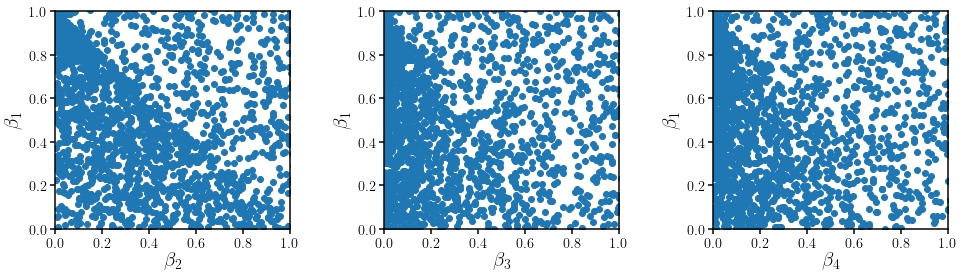

In [6]:
fig = plt.figure(figsize=(16,4))
for i in range(3): 
    sub = fig.add_subplot(1,3,i+1)
    sub.scatter(theta_train[:,i+1], theta_train[:,0])
    sub.set_xlabel(r'$\beta_{%i}$' % (i+2), fontsize=20)
    sub.set_xlim(0, 1)
    sub.set_ylabel(r'$\beta_1$', fontsize=20)
    sub.set_ylim(0, 1)
fig.subplots_adjust(wspace=0.4)

Now that we have the parameters for our training sample. Lets generate FSPS spectra for each of them

In [7]:
spectra_train = []
for _theta in theta_train: 
    w_fsps, _spectrum = speculate._fsps_model(_theta)
    spectra_train.append(_spectrum)

/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/gqp_mc/fitters.py:2425: RuntimeWarning: divide by zero encountered in log10
  self._ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)


(0.0, 0.005)

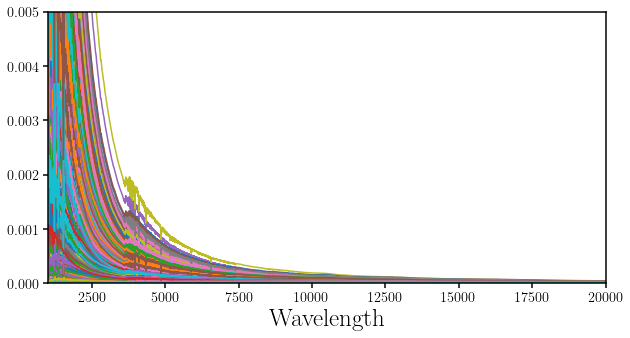

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for _spectrum in spectra_train: 
    sub.plot(w_fsps, _spectrum)
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim(1e3, 2e4)
sub.set_ylim(0, 0.005)

# Impose wavelength range

In [9]:
wmin = 2300.
wmax = 11030.
wlim = (w_fsps >= wmin) & (w_fsps <= wmax)
print('%i wavelength bins from %.2f < w < %.2f' % (np.sum(wlim), w_fsps[wlim].min(), w_fsps[wlim].max()))

4469 wavelength bins from 2305.00 < w < 11025.00


# save to file

In [10]:
ftheta = os.path.join(UT.dat_dir(), 'speculator', 'DESI_simpledust.theta_train.npy')
fwave = os.path.join(UT.dat_dir(), 'speculator', 'wave_fsps.npy')
fspectrum = os.path.join(UT.dat_dir(), 'speculator', 'DESI_simpledust.spectrum_fsps_train.npy')

In [11]:
np.save(ftheta, theta_train)

In [12]:
np.save(fwave, w_fsps[wlim])

In [13]:
np.save(fspectrum, np.array(spectra_train)[:,wlim])